<h1 align="center">Volume 2: The Fourier Transform.</h1>

    <Jake Callahan>
    <Section 002 Volume 2>
    <2018/12/04>

<h2 align="center">Part 1: The Discrete Fourier Transform</h2>

In [1]:
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft, fft2, ifft2
from scipy.linalg import dft
from scipy.io import wavfile
from scipy.signal import fftconvolve
import numpy as np
import IPython
import time
import math

In [2]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

In [3]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples

    # Problems 1.1 and 1.7
    def plot(self, plot_transform = False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        
        if plot_transform == False:
            time = np.linspace(0, len(self.samples) / self.rate, len(self.samples))
        
            plt.plot(time, self.samples)
            plt.ylim((-32768,32767))
            plt.title("Waveform")
        
            plt.show()
        
        if plot_transform == True:
            transform = np.abs(fft(self.samples))
            
            time = np.linspace(0, len(self.samples) / self.rate, len(self.samples))
            freq = np.arange(0, len(self.samples)) * self.rate / len(samples)
            
            ax2 = plt.subplot(121)
            ax2.plot(time, self.samples)
            ax2.set_ylim((-32768, 32767))
            ax2.set_title("Waveform")
            
            ax1 = plt.subplot(122)
            ax1.plot(freq, transform)
            ax1.set_xlim((0,self.rate / 2))
            ax1.set_title("Frequencies")
                         
            plt.show()

    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        if force==True or self.samples.dtype!='int16':
            scaled_samples = np.int16((self.samples * 32767.0)/max(self.samples))
            wavfile.write(filename, self.rate, scaled_samples)
            
        else:
            wavfile.write(filename, self.rate, self.samples)
    
    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        if len(self.samples)!=len(other.samples):
            raise ValueError("Samples not the same length!")
            
        new_sample = self.samples + other.samples
        return SoundWave(self.rate, new_sample)
        

    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("Samples not the same length!")
            
        new_sample = np.concatenate((self.samples, other.samples))
        
        return SoundWave(self.rate, new_sample)
    
    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        #Ensure rates are the same
        if self.rate!=other.rate:
            raise ValueError("Sample rates are different!")
        
        #Pad smaller array with zeros
        if len(self.samples)< len(other.samples):
            padded_f = np.concatenate((self.samples,np.zeros(len(other.samples) - len(self.samples))))
            padded_g = other.samples
        elif len(self.samples)>len(other.samples):
            padded_g = np.concatenate((other.samples,np.zeros(len(self.samples) - len(other.samples))))
            padded_f = self.samples
            
        #Get transformed sample sets to multipy component wise
        f_trans = fft(padded_f).real
        g_trans = fft(padded_g).real
        
        hadamard = np.multiply(f_trans,g_trans)
        
        convolution = ifft(hadamard).real
        
        #Return new SoundWave with rate = self.rate and samples = our convoluted SoundWaves
        return SoundWave(self.rate, convolution)


    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        #Get lengths to use
        n = len(self.samples)
        m = len(other.samples)
        sample_length = n + m - 1
  
        #Find smallest power of 2 >= n + m - 1
        while math.log(sample_length, 2) != int(math.log(sample_length, 2)):
            sample_length += 1
            
        #Pad samples with zeros
        padded_f = np.concatenate((self.samples,np.zeros(sample_length - n)))
        padded_g = np.concatenate((other.samples,np.zeros(sample_length - m)))
           
        #Transform and get hadamard
        hadamard = np.multiply(fft(padded_f).real, fft(padded_g).real)
        
        #Inverse fourier transform on the hadamard product
        convolution = ifft(hadamard).real
     
        #Return new SoundWave with rate = self.rate and samples = our convoluted SoundWaves
        return SoundWave(self.rate, convolution[:n+m-1])
    
    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        #Get frequency by  set and length of sample size
        f = fft(self.samples)
        n = len(self.samples)
        
        #Find k_low and k_high using k = nv/r
        k_low = int(n*low_freq/self.rate)
        k_high = int(n*high_freq/self.rate)
        
        #Replace both intervals of high frequency with zero
        zeros = [0]*len(f)
        f[k_low:k_high] = zeros[k_low:k_high]
        f[n-k_high:n-k_low] = zeros[n-k_high:n-k_low]

        return SoundWave(self.rate, ifft(f).real)

### Problem 1.1

- Implement `SoundWave.__init__()`.
- Implement `SoundWave.plot()`.
- Use the `scipy.io.wavefile.read()` and the `SoundWave` class to plot `tada.wav`.

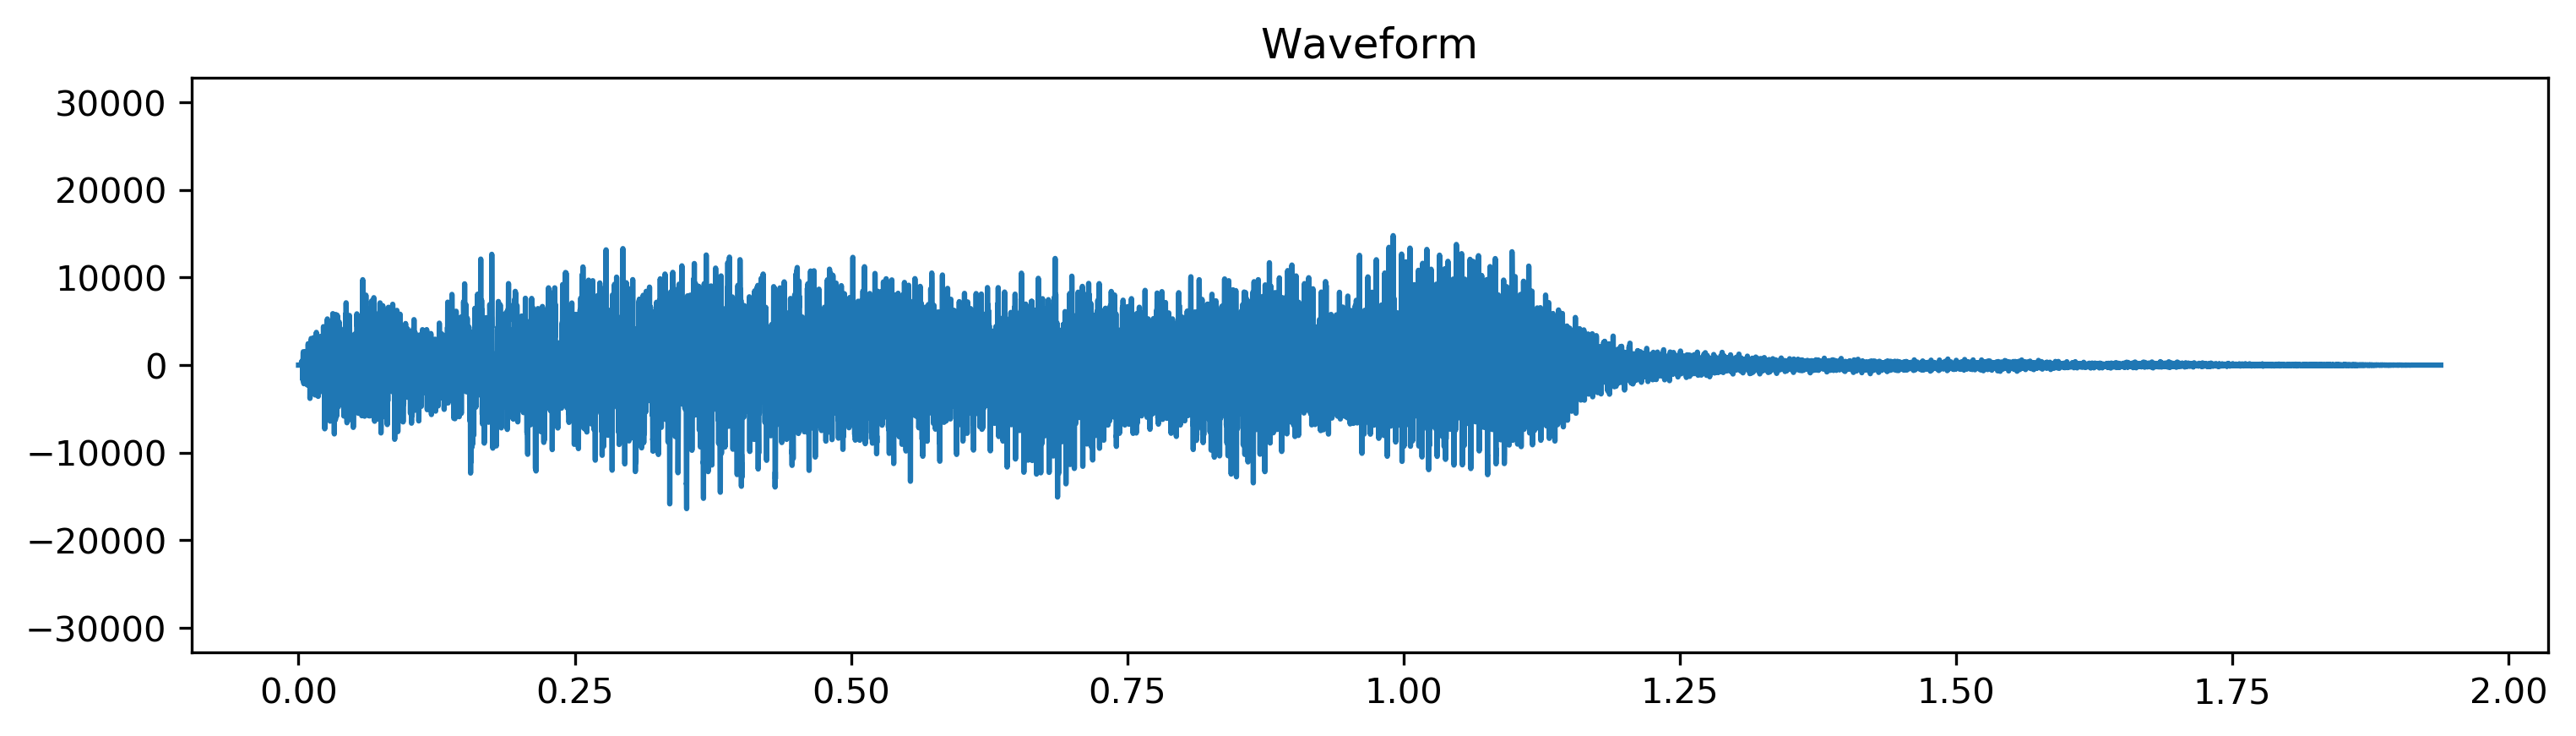

In [4]:
rate, samples = wavfile.read("tada.wav")
tada = SoundWave(rate, samples)
tada.plot()

### Problem 1.2

- Implement `SoundWave.export()`.
- Use the `export()` method to create two new files containing the same sound as `tada.wav`: one without scaling, and one with scaling (use `force=True`).
- Use `IPython.display.Audio()` to embed the original and new versions of `tada.wav` in the notebook.

In [5]:
tada.export("new_tada.wav", force=False)
tada.export("new_tada_scaled.wav", force=True)

IPython.display.Audio(filename="tada.wav")

In [6]:
IPython.display.Audio(filename="new_tada.wav")

In [7]:
IPython.display.Audio(filename="new_tada_scaled.wav")

### Problem 1.3

- Implement `generate_note()`.
- Use `generate_note()` to create an A tone that lasts for two seconds. Embed it in the notebook.

In [8]:
def generate_note(frequency, duration):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    rate = 44100
    x = np.linspace(0, duration, rate * duration)
    samples = np.sin(2*np.pi*frequency*x)

    return SoundWave(rate, samples)

In [9]:
A = generate_note(440, 2)
A.export("A_note.wav")
IPython.display.Audio(filename="A_note.wav")

### Problem 1.4

- Implement `SoundWave.__add__()`.
- Generate a three-second A minor chord (A, C, and E) and embed it in the notebook.
- Implement `SoundWave.__rshift__()`.
- Generate the arpeggio A$\,\rightarrow\,$C$\,\rightarrow\,$E, where each tone lasts one second, and embed it in the notebook.

In [10]:
A = generate_note(440, 3)
C = generate_note(523.25, 3)
E = generate_note(659.25, 3)

Amin = A + C + E
Amin.export("A_minor.wav")
IPython.display.Audio(filename="A_minor.wav")

In [11]:
A = generate_note(440, 1)
C = generate_note(523.25, 1)
E = generate_note(659.25, 1)

Aarpegg = A >> C >> E
Aarpegg.export("A_arpegg.wav")
IPython.display.Audio(filename="A_arpegg.wav")

### Problem 1.5

- Implement `simple_dft()` with the formula for $c_k$ given below.
- Use `np.allclose()` to check that `simple_dft()` and `scipy.fftpack.fft()` give the same result (after scaling).

$$
c_k = \frac{1}{n}\sum_{\ell=0}^{n-1} f_\ell e^{-2 \pi i k \ell\, /\, n}
$$

In [12]:
def simple_dft(samples):
    """Compute the DFT of an array of samples.

    Parameters:
        samples ((n,) ndarray): an array of samples.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    n = len(samples)
    kl = np.outer(np.arange(n), np.arange(n))
    return 1/n*np.exp(-2j*np.pi*kl/n) @ samples
    

In [13]:
f = np.random.random(2**10)
np.allclose(len(f)*simple_dft(f), fft(f))

True

### Problem 1.6

- Implement `simple_fft()`.
- Generate an array of $8192$ random samples and take its DFT using `simple_dft()`, `simple_fft()`, and `scipy.fftpack.fft()`.
Print the runtimes of each computation.
- Use `np.allclose()` to check that `simple_fft()` and `scipy.fftpack.fft()` give the same result (after scaling).

In [14]:
def simple_fft(samples, threshold=1):
    """Compute the DFT using the FFT algorithm.
    
    Parameters:
        samples ((n,) ndarray): an array of samples.
        threshold (int): when a subarray of samples has fewer
            elements than this integer, use simple_dft() to
            compute the DFT of that subarray.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    n = len(samples)
    
    if n <= threshold:
        return simple_dft(samples)
    else:
        samples_even = simple_fft(samples[::2])
        samples_odd = simple_fft(samples[1::2])
        w = np.exp((-2j * np.pi/n) * np.arange(n))
        first_sum = samples_even + w[:n//2] * samples_odd
        second_sum = samples_even + w[n//2:] * samples_odd
        return 0.5*np.concatenate([first_sum, second_sum])

In [15]:
f = np.random.random(8192)

print("Same result post scaling: ", np.allclose(len(f) * simple_fft(f), fft(f)))
print()
start = time.time()
simple_dft(f)
end = time.time()
print("simple_dft: ", end - start, "seconds")

start = time.time()
simple_fft(f)
end = time.time()
print("simple_fft: ", end - start, "seconds")

start = time.time()
fft(f)
end = time.time()
print("scipy.fftpack.fft: ", end - start, "seconds")

Same result post scaling:  True

simple_dft:  10.62257170677185 seconds
simple_fft:  0.24306821823120117 seconds
scipy.fftpack.fft:  0.0004069805145263672 seconds


### Problem 1.7

- Modify `SoundWave.plot()` so that it accepts a boolean. When the boolean is `True`, take the DFT of the stored samples and plot (in a new subplot) the frequencies present on the $x$-axis and the magnituds of those frequences on the $y$-axis. Only the display the first half of the plot, and adjust the $x$-axis so that it correctly shows the frequencies in Hertz.
- Display the plot of the DFT of an A tone.
- Display the plot of the DFT of an A minor chord.

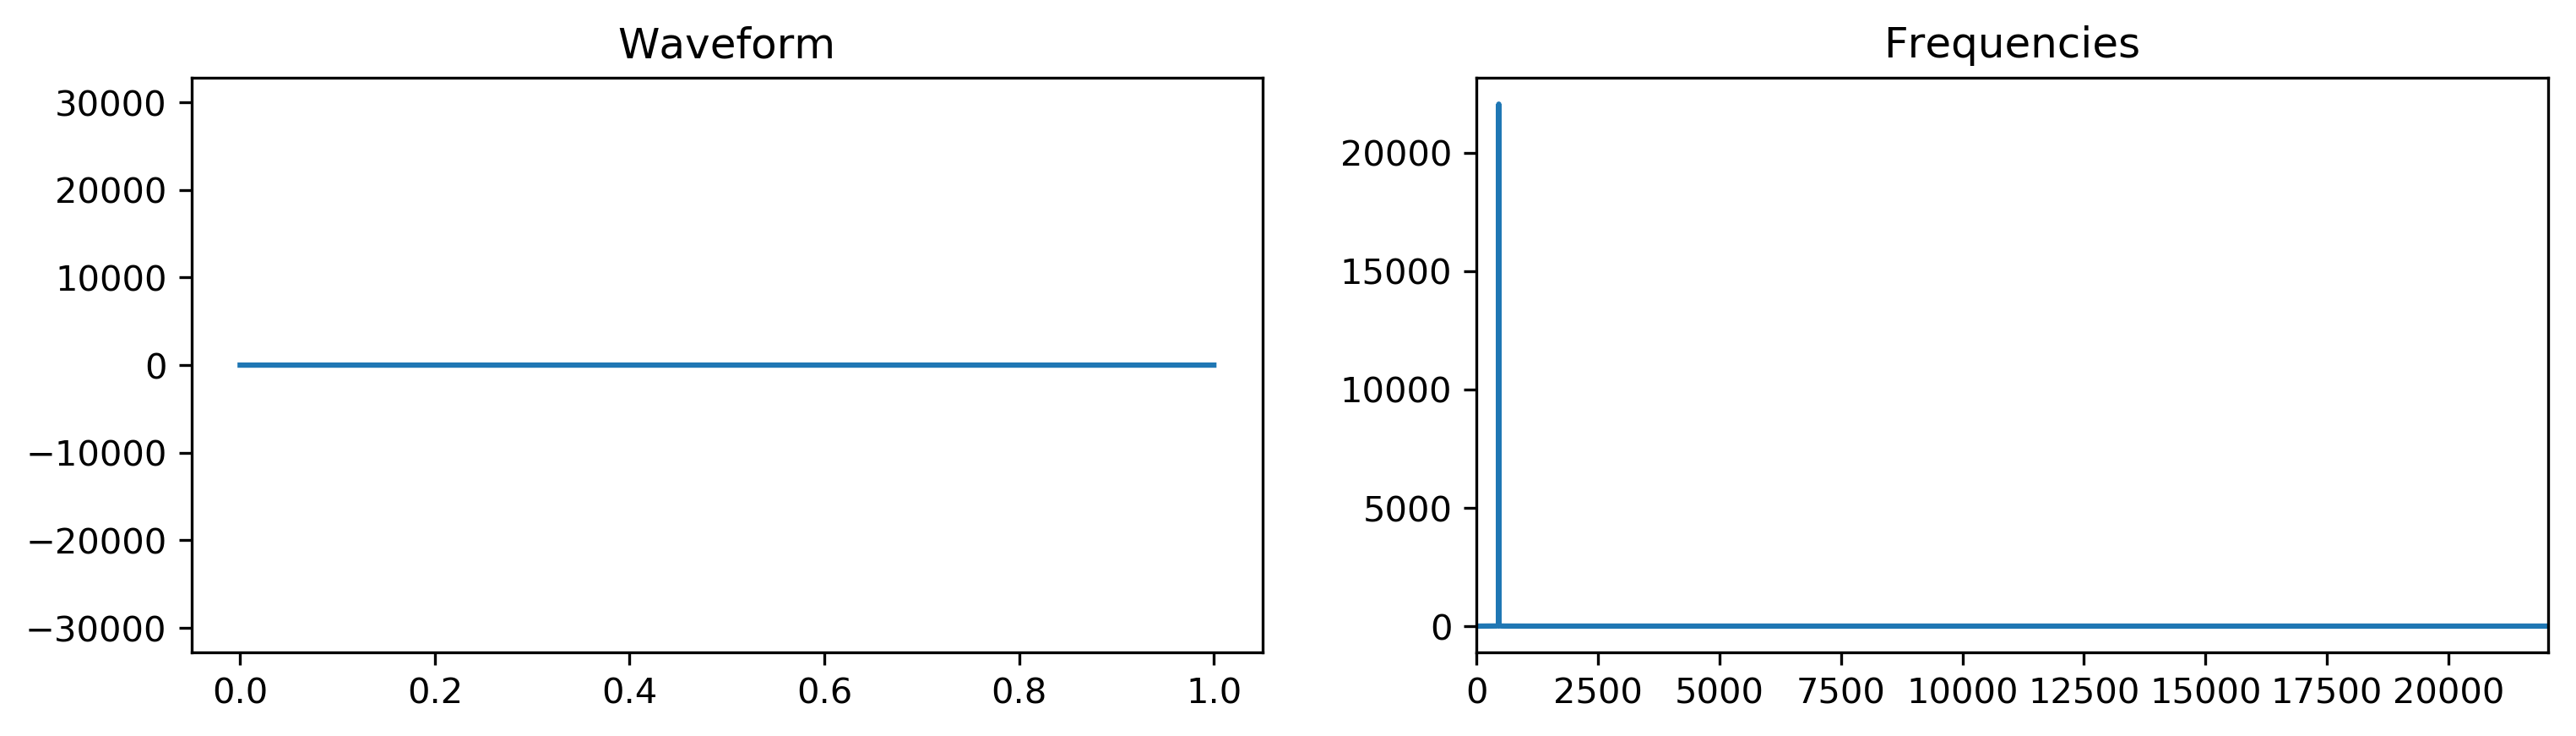

In [16]:
A.plot(True)

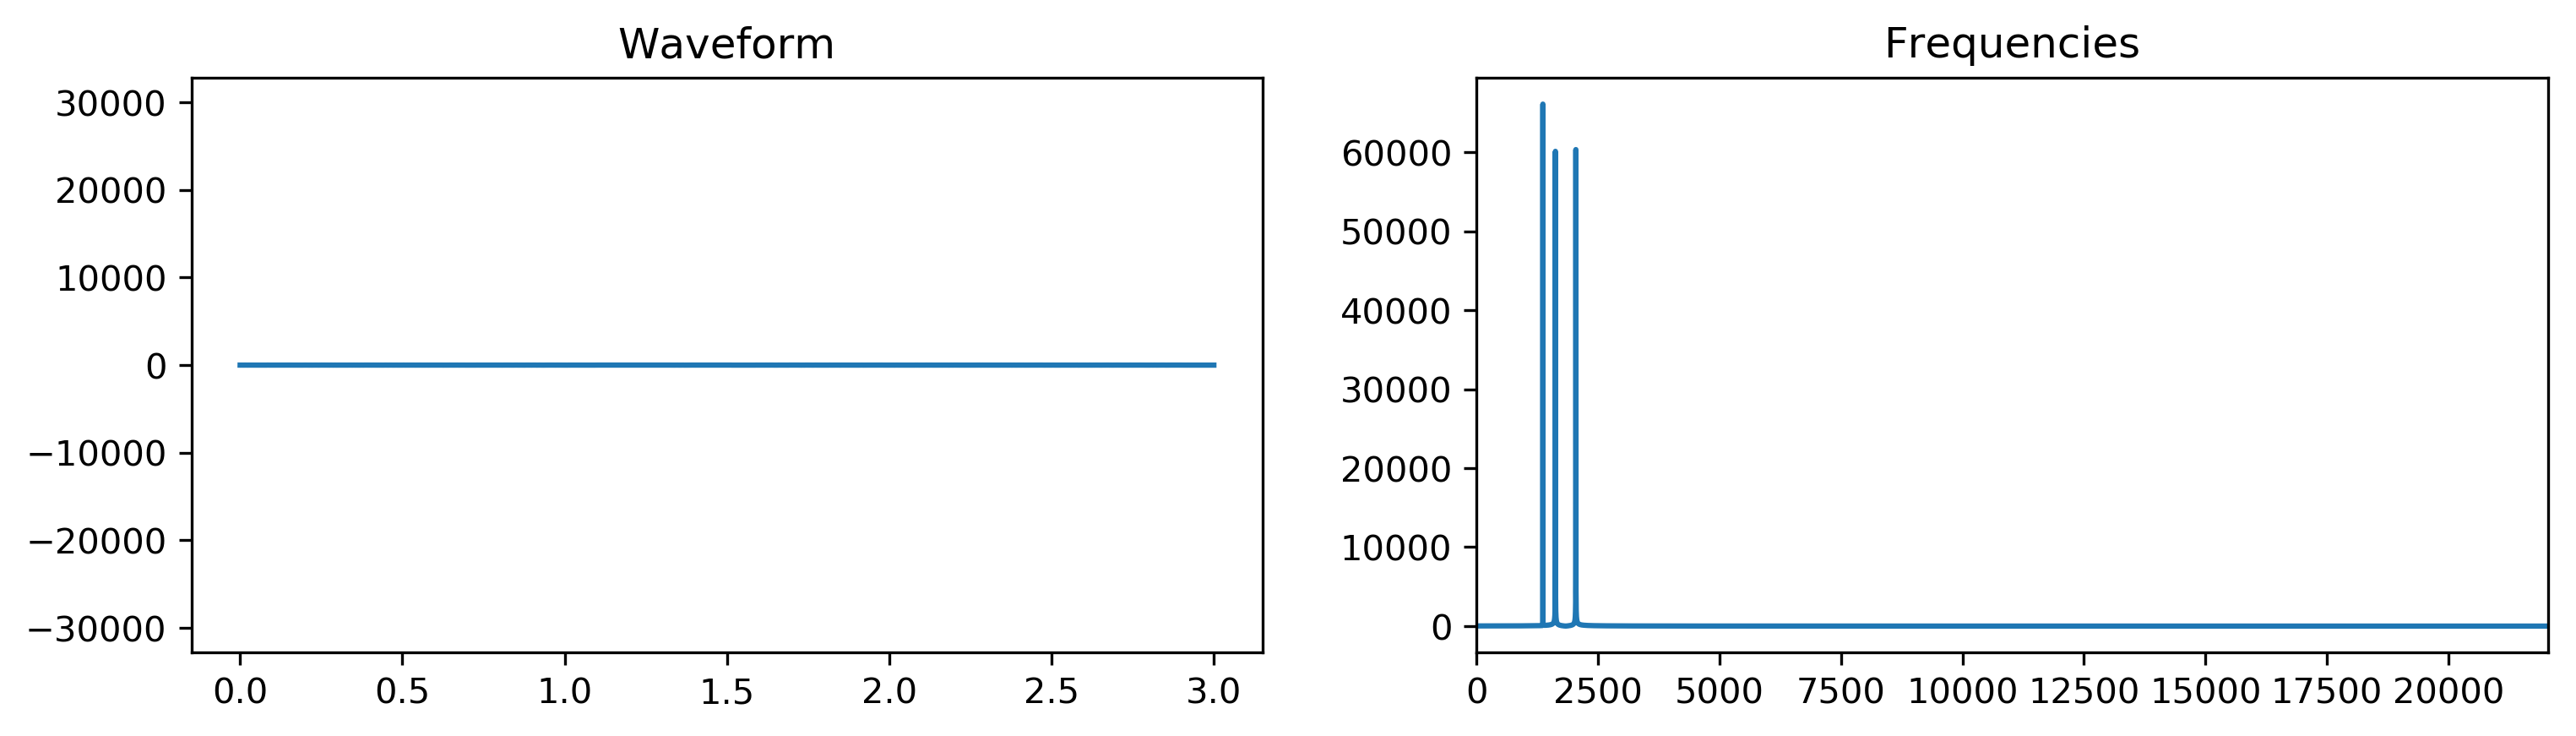

In [17]:
Amin.plot(True)

### Problem 1.8

Use the DFT to determine the individual notes that are present in `mystery_chord.wav`.

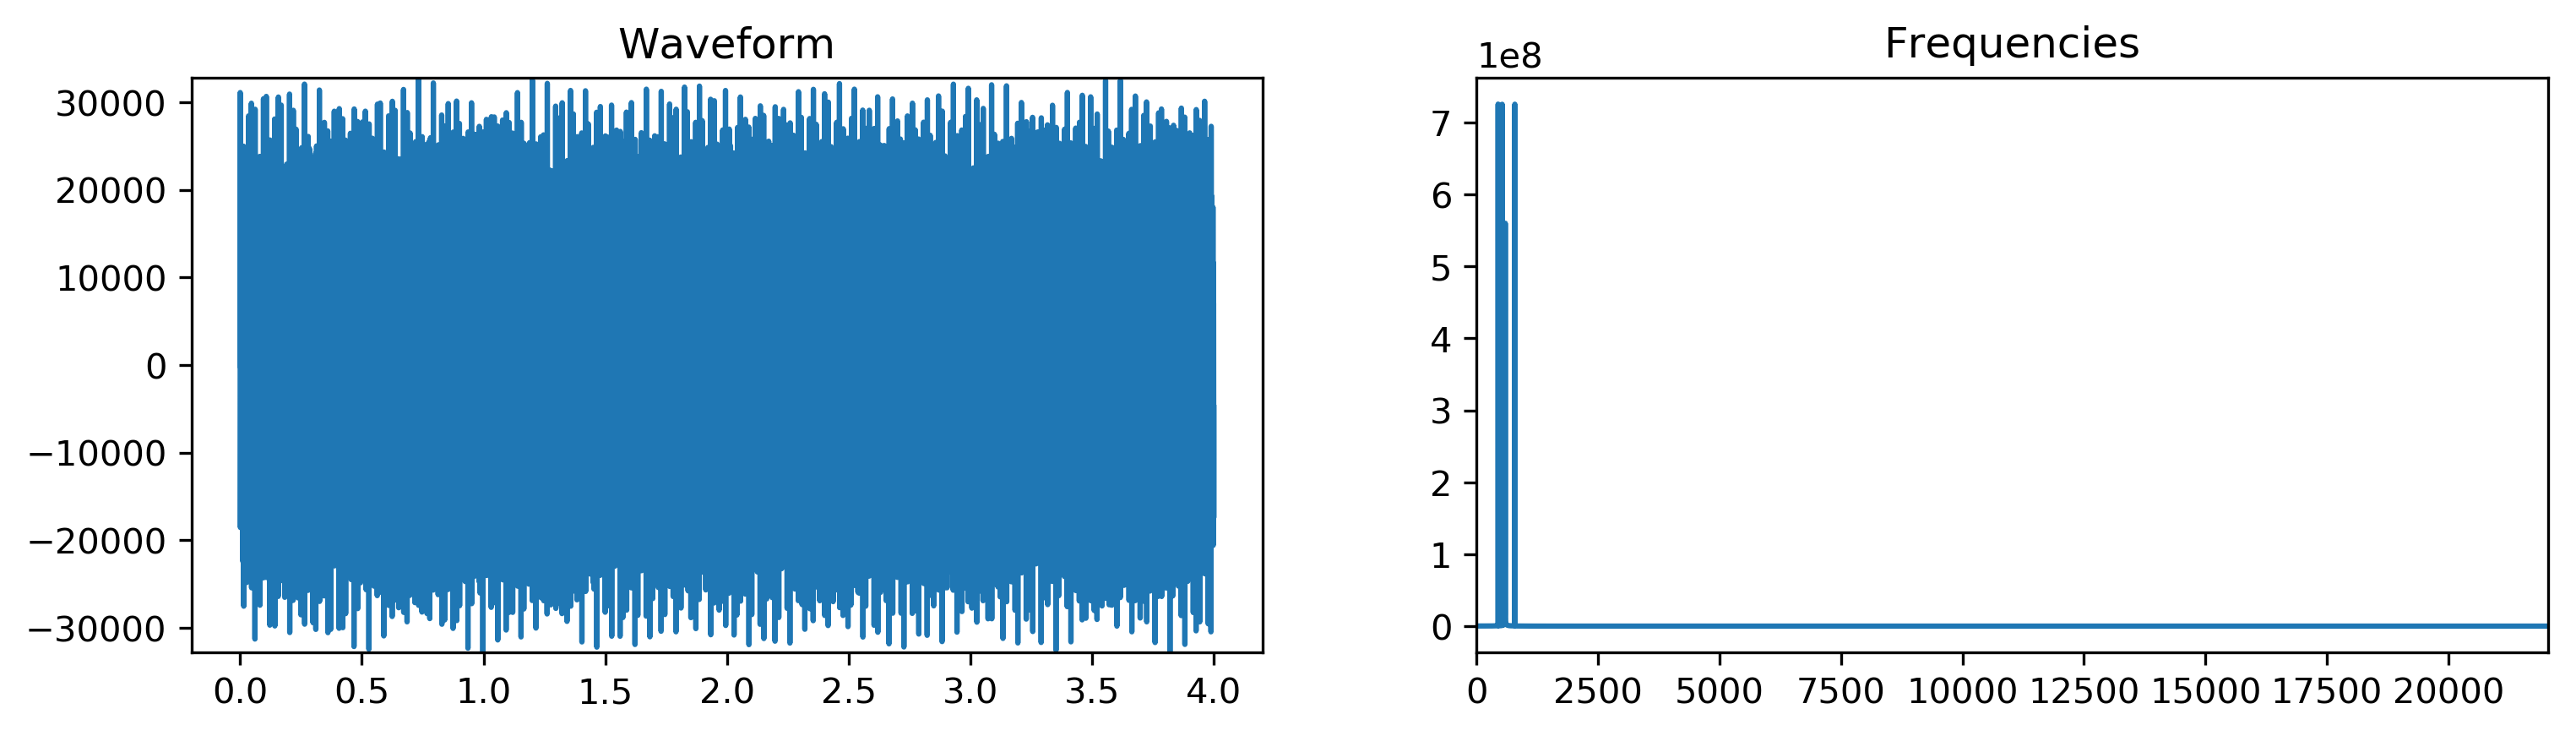

In [18]:
rate, samples = wavfile.read("mystery_chord.wav")
mystery_chord = SoundWave(rate, samples)
mystery_chord.plot(True)

In [19]:
mag = np.abs(fft(mystery_chord.samples))
sort = np.argsort(mag[:len(mystery_chord.samples)//2])[::-1]
print("First frequency:", sort[0] * rate/len(samples))
print("Second frequency:", sort[1] * rate/len(samples))
print("Third frequency:", sort[2] * rate/len(samples))
print("Fourth frequency:", sort[3])
print()
IPython.display.Audio(filename="mystery_chord.wav")


First frequency: 440.0
Second frequency: 784.0
Third frequency: 523.25
Fourth frequency: 2350



The notes are...
A, G, C, and D

<h2 align="center">Part 2: Convolution and Filtering.</h2>

### Problem 2.1

- Implement `SoundWave.__mul__()` for circular convolution.
- Generate 2 seconds of white noise at the same sample rate as `tada.wav`.
- Compute the circular convolution of `tada.wav` and the white noise. Embed the result in the notebook.
- Append the circular convolution to itself and embed the result in the notebook.

In [20]:
rate = 22050 # Create 2 seconds of white noise at a given rate.
white_noise = np.random.randint(-32767, 32767, rate*2, dtype=np.int16)
white_noise = SoundWave(rate, white_noise)
convoluted_tada = tada * white_noise
convoluted_tada = convoluted_tada >> convoluted_tada

In [21]:
#Embed convoluted tada
convoluted_tada.export("convoluted_tada.wav")
IPython.display.Audio(filename="convoluted_tada.wav")

### Problem 2.2

- Implement `SoundWave.__pow__()` for linear convolution.
- Time the linear convolution of `CGC.wav` and `GCG.wav` using `SoundWave.__pow__()` and `scipy.signal.fftconvolve()`.
- Embed the two original sounds and their convolutions in the notebook. Check that the convolutions with `SoundWave.__pow__()` and `scipy.signal.fftconvolve()` sound the same.

In [22]:
#Embed CGC
rate, samples = wavfile.read("CGC.wav")
CGC = SoundWave(rate, samples)
CGC.export("CGC.wav")
IPython.display.Audio(filename="CGC.wav")

In [23]:
#Embed GCG
rate, samples = wavfile.read("GCG.wav")
GCG = SoundWave(rate, samples)
GCG.export("GCG.wav")
IPython.display.Audio(filename="GCG.wav")

In [24]:
#Get CGC and GCG
rate, samples = wavfile.read("CGC.wav")
CGC = SoundWave(rate, samples)
rate, samples = wavfile.read("GCG.wav")
GCG = SoundWave(rate, samples)

#Convolve the two using __pow__()
arpegg_convolve = CGC**GCG

#Embed the convolution
arpegg_convolve.export("arpegg_convolve.wav")
IPython.display.Audio(filename="arpegg_convolve.wav")

In [25]:
#Time __pow__()
start = time.time()
arpegg_convolve = CGC**GCG
end = time.time()
print("My linear convolution: ", end-start)

#Time signal.fftconvolve()
start = time.time()
arpegg_convolve = fftconvolve(CGC.samples, CGC.samples)
end = time.time()
print("signal.fftconvolve: ", end-start)


My linear convolution:  0.3461160659790039
signal.fftconvolve:  0.05900692939758301


### Problem 2.3

Use `SoundWave.__pow__()` or `scipy.signal.fftconvolve()` to compute the linear convolution of `chopin.wav` and `balloon.wav`.
Embed the two original sounds and their convolution in the notebook.

In [26]:
#Embed chopin
rate, samples = wavfile.read("chopin.wav")
chopin = SoundWave(rate, samples)
IPython.display.Audio(filename="chopin.wav")

In [27]:
#Embed balloon
rate, samples = wavfile.read("balloon.wav")
balloon = SoundWave(rate, samples)
IPython.display.Audio(filename="balloon.wav")

In [28]:
#Convolve chopin and balloon using fftconvolve and embed
concert_hall = SoundWave(chopin.rate, fftconvolve(chopin.samples, balloon.samples))
concert_hall.export("concert_hall.wav")
IPython.display.Audio("concert_hall.wav")

### Problem 2.4

- Implement `SoundWave.clean()`.
- Clean `noisy1.wav` by filtering out frequencies from $1250$-$2600$ Hz. Embed the original and the cleaned versions in the notebook.
- Clean `noisy2.wav`. Embed the original and the cleaned versions in the notebook.

In [31]:
#Embed original noisy1 and show
IPython.display.Audio("noisy1.wav")

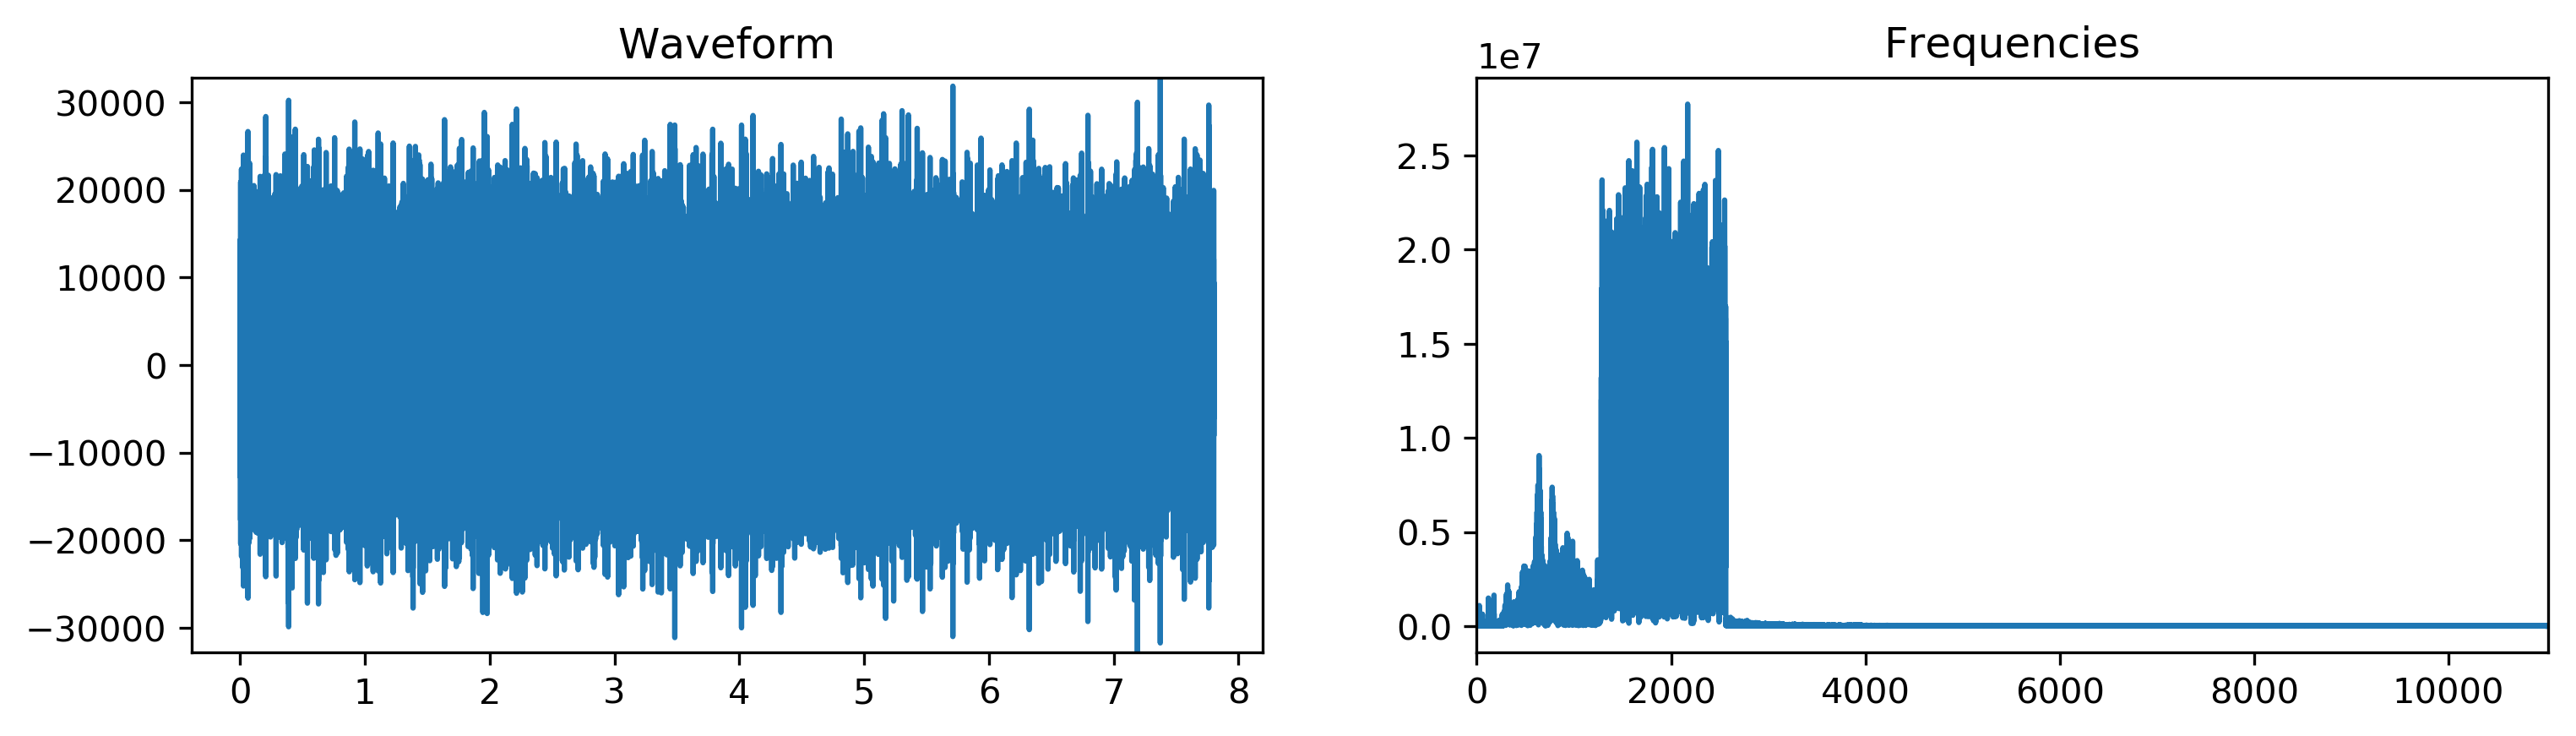

In [34]:
#Show noisy1.wav waveform and frequencies
rate, samples = wavfile.read("noisy1.wav")
noisy1 = SoundWave(rate, samples)
noisy1.plot(True)

In [35]:
#Embed clean noisy1
noisy1_clean = noisy1.clean(1000,2600)
noisy1_clean.export("noisy1_clean.wav")
IPython.display.Audio("noisy1_clean.wav")

In [ ]:
IPython.display.Audio("noisy2.wav")

In [ ]:
#Embed original noisy2 and show
rate, samples = wavfile.read("noisy2.wav")
noisy2 = SoundWave(rate, samples)
noisy2.plot(True)

In [ ]:
#Get original noisy2
rate, samples = wavfile.read("noisy2.wav")
noisy2 = SoundWave(rate, samples)

#Embed cleaned noisy2
noisy2_clean = noisy2.clean(1300,4500)
noisy2_clean.export("noisy2_clean.wav")
IPython.display.Audio("noisy2_clean.wav")


### Problem 2.5

- Clean `vuvuzela.wav` by filtering bad frequencies out of the left and right channels individually.
- Recombine the left and right channels and embed the result in the notebook.

In [ ]:
#Get embed vuvuzela
rate, samples = wavfile.read("vuvuzela.wav")

IPython.display.Audio("vuvuzela.wav")

In [ ]:
#Get and clean channels and embed cleaned vuvuzela file
rate, samples = wavfile.read("vuvuzela.wav")

#Clean channels
channel1 = SoundWave(rate, samples[:,0]).clean(200,500)
channel2 = SoundWave(rate, samples[:,1]).clean(200,500)

#Combine channels into one array
clean_samples = (np.vstack((channel1_clean.samples, channel2_clean.samples)))

IPython.display.Audio(rate=vuvuzela.rate, data=clean_samples)

### Problem 2.6

- Clean up `license_plate.png` so that the year printed on the sticker in the bottom right corner of the plate is legible.
- Display the original and cleaned images.

In [ ]:
# Read the image.
import imageio
im = imageio.imread("license_plate.png")
# Plot the log magnitude of the image's DFT.
im_dft = fft2(im)
plt.imshow(np.log(np.abs(im_dft)), cmap="gray")
plt.show()

In [ ]:
#Get ifft of im
im_dft = fft2(im)

#Clean up abnormalities in the image
im_dft[30:40,95:105] = [[np.mean(im_dft)]*10]*10
im_dft[65:78,196:209] = [[np.mean(im_dft)]*13]*13
im_dft[107:117,128:138] = [[np.mean(im_dft)]*10]*10
im_dft[141:151,228:238] = [[np.mean(im_dft)]*10]*10
im_dft[100:110,300:310] = [[np.mean(im_dft)]*10]*10
im_dft[174:189,324:339] = [[np.mean(im_dft)]*15]*15

#plt.imshow(np.log(np.abs(im_dft)), cmap="gray")
plt.imshow(ifft2(im_dft).real, cmap="gray")
plt.show()

The year on the sticker is... the year of our Lord 2013